In [2]:
# Cell 1: imports
import os
import numpy as np
import matplotlib.pyplot as plt
import itertools
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


In [9]:
# Cell 2: paths
import os

BASE = os.path.join("..","..")  # if running inside ml/notebooks
RAW_DIR = os.path.join(BASE, "ml", "data", "raw")
PROC_DIR = os.path.join(BASE, "ml", "data", "processed")
MODEL_DIR = os.path.join(BASE, "ml", "models")
os.makedirs(MODEL_DIR, exist_ok=True)

# Train/Test directories
TRAIN_DIR = os.path.join(RAW_DIR, "train")
TEST_DIR  = os.path.join(RAW_DIR, "test")

# Your emotion classes (confirm with your dataset)
CLASS_NAMES = ['angry','disgust','fear','happy','sad','surprise','neutral']
IMG_SIZE = (48,48)
BATCH_SIZE = 64


In [4]:
# Cell 3: if you need to create train/val/test from a master folder with subfolders
import shutil, random
from pathlib import Path

src = Path(RAW_DIR)  # structure: raw/<class>/<images>
dst = Path(PROC_DIR)
for split in ["train","val","test"]:
    for c in CLASS_NAMES:
        (dst / split / c).mkdir(parents=True, exist_ok=True)

# Simple stratified split (70/15/15)
for c in CLASS_NAMES:
    files = list((src / c).glob("*"))
    random.shuffle(files)
    n = len(files)
    n_train = int(0.70 * n)
    n_val = int(0.15 * n)
    train_files = files[:n_train]
    val_files = files[n_train:n_train+n_val]
    test_files = files[n_train+n_val:]
    for f in train_files:
        shutil.copy(f, dst / "train" / c / f.name)
    for f in val_files:
        shutil.copy(f, dst / "val" / c / f.name)
    for f in test_files:
        shutil.copy(f, dst / "test" / c / f.name)


In [1]:
# Cell 4: generators
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Training data generator with validation split
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,  # 20% of train data goes to validation
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Training set
train_gen = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset="training",
    shuffle=True
)

# Validation set
val_gen = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset="validation",
    shuffle=True
)

# Test set (already separated)
test_gen = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print("Classes:", train_gen.class_indices)


NameError: name 'TRAIN_DIR' is not defined

In [11]:
# Cell 5: baseline model
def build_baseline(input_shape=(48,48,1), num_classes=len(CLASS_NAMES)):
    model = models.Sequential()
    model.add(layers.Input(shape=input_shape))

    model.add(layers.Conv2D(32, (3,3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Dropout(0.25))

    model.add(layers.Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Dropout(0.25))

    model.add(layers.Conv2D(128, (3,3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Dropout(0.25))

    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))
    return model

model = build_baseline((IMG_SIZE[0], IMG_SIZE[1], 1))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 684,935 (2.61 MB)

 Trainable params: 684,231 (2.61 MB)

 Non-trainable params: 704 (2.75 KB)

In [13]:
# Cell 6: callbacks + fit
checkpoint_path = os.path.join(MODEL_DIR, "best_baseline.h5")
tensorboard_log_dir = os.path.join(BASE, "ml", "logs")

callbacks = [
    ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, verbose=1),
    TensorBoard(log_dir=tensorboard_log_dir)
]


EPOCHS = 10  # on CPU, start with 10-20
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=callbacks
)


Epoch 1/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step - accuracy: 0.3201 - loss: 1.7703

d:\Infosys SpringBoard\EmoTune\venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_accuracy improved from None to 0.31998, saving model to ..\..\ml\models\best_baseline.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 269s 750ms/step - accuracy: 0.3428 - loss: 1.7109 - val_accuracy: 0.3200 - val_loss: 1.9303 - learning_rate: 0.0010
Epoch 2/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.3894 - loss: 1.5790
Epoch 2: val_accuracy did not improve from 0.31998
359/359 ━━━━━━━━━━━━━━━━━━━━ 53s 147ms/step - accuracy: 0.4005 - loss: 1.5525 - val_accuracy: 0.3132 - val_loss: 1.8689 - learning_rate: 0.0010
Epoch 3/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.4180 - loss: 1.5048
Epoch 3: val_accuracy improved from 0.31998 to 0.41822, saving model to ..\..\ml\models\best_baseline.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 58s 161ms/step - accuracy: 0.4245 - loss: 1.4861 - val_accuracy: 0.4182 - val_loss: 1.5128 - learning_rate: 0.0010
Epoch 4/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - accuracy: 0.4456 - loss: 1.4456
Epoch 4: val_accuracy did not improve from 0.41822
359/359 ━━━━━━━━━━━━━━━━━━━━ 118s 261ms/step - accuracy: 0.4510 - loss: 1.4344 - val_accuracy: 0.4069 - val_loss: 1.5641 - learning_rate: 0.0010
Epoch 5/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - accuracy: 0.4625 - loss: 1.4035
Epoch 5: val_accuracy improved from 0.41822 to 0.46595, saving model to ..\..\ml\models\best_baseline.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 110s 306ms/step - accuracy: 0.4669 - loss: 1.3966 - val_accuracy: 0.4659 - val_loss: 1.4043 - learning_rate: 0.0010
Epoch 6/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.4788 - loss: 1.3711
Epoch 6: val_accuracy improved from 0.46595 to 0.46891, saving model to ..\..\ml\models\best_baseline.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 71s 197ms/step - accuracy: 0.4773 - loss: 1.3744 - val_accuracy: 0.4689 - val_loss: 1.4238 - learning_rate: 0.0010
Epoch 7/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.4876 - loss: 1.3560
Epoch 7: val_accuracy improved from 0.46891 to 0.49626, saving model to ..\..\ml\models\best_baseline.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 70s 194ms/step - accuracy: 0.4834 - loss: 1.3525 - val_accuracy: 0.4963 - val_loss: 1.3067 - learning_rate: 0.0010
Epoch 8/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.4924 - loss: 1.3366
Epoch 8: val_accuracy improved from 0.49626 to 0.51663, saving model to ..\..\ml\models\best_baseline.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 74s 205ms/step - accuracy: 0.4932 - loss: 1.3311 - val_accuracy: 0.5166 - val_loss: 1.2625 - learning_rate: 0.0010
Epoch 9/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.5039 - loss: 1.3130
Epoch 9: val_accuracy did not improve from 0.51663
359/359 ━━━━━━━━━━━━━━━━━━━━ 56s 156ms/step - accuracy: 0.5044 - loss: 1.3162 - val_accuracy: 0.4959 - val_loss: 1.3178 - learning_rate: 0.0010
Epoch 10/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.5090 - loss: 1.2972
Epoch 10: val_accuracy did not improve from 0.51663
359/359 ━━━━━━━━━━━━━━━━━━━━ 52s 146ms/step - accuracy: 0.5091 - loss: 1.2984 - val_accuracy: 0.4896 - val_loss: 1.3763 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 8.


113/113 ━━━━━━━━━━━━━━━━━━━━ 110s 978ms/step - accuracy: 0.5344 - loss: 1.2003
Test loss: 1.2003121376037598 Test acc: 0.5344107151031494
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step
              precision    recall  f1-score   support

       angry       0.47      0.38      0.42       958
     disgust       0.64      0.08      0.14       111
        fear       0.42      0.11      0.18      1024
       happy       0.63      0.88      0.73      1774
     neutral       0.43      0.64      0.52      1233
         sad       0.45      0.31      0.37      1247
    surprise       0.66      0.73      0.69       831

    accuracy                           0.53      7178
   macro avg       0.53      0.45      0.44      7178
weighted avg       0.52      0.53      0.50      7178



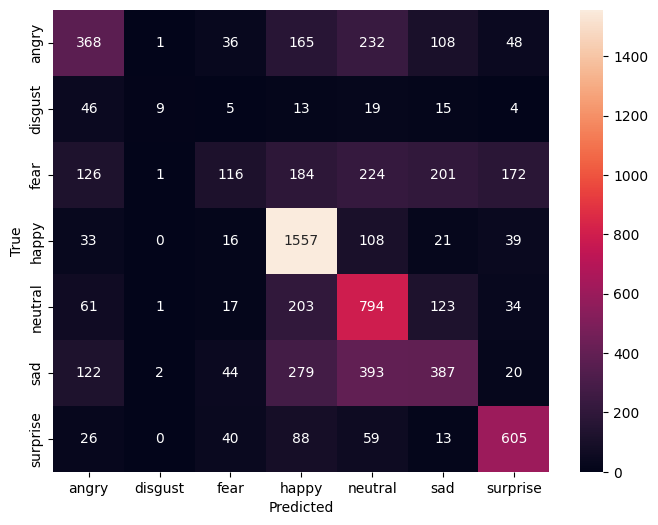

In [14]:
# Cell 7: evaluate
model.load_weights(checkpoint_path)
loss, acc = model.evaluate(test_gen)
print("Test loss:", loss, "Test acc:", acc)

# Predictions for classification report
y_true = test_gen.classes
y_pred_proba = model.predict(test_gen)
y_pred = np.argmax(y_pred_proba, axis=1)
print(classification_report(y_true, y_pred, target_names=list(test_gen.class_indices.keys())))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=list(test_gen.class_indices.keys()), yticklabels=list(test_gen.class_indices.keys()))
plt.ylabel('True'); plt.xlabel('Predicted');


In [19]:
model.save(os.path.join(MODEL_DIR, "emotune_savedmodel.keras"))


In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.utils import class_weight


In [7]:
import os

BASE_DIR = "ml/data/new_data"
TRAIN_DIR = os.path.join(BASE_DIR, "train")
VAL_DIR = os.path.join(BASE_DIR, "val")
TEST_DIR = os.path.join(BASE_DIR, "test")

IMG_SIZE = (75, 75)   # since your dataset is 75x75
BATCH_SIZE = 32
SEED = 42


In [9]:
# IMG_SIZE = (75, 75)   # <-- change to (48,48) if you want to match previous model
# BATCH_SIZE = 64
EPOCHS = 40
# SEED = 42
MODEL_OUT = "ml/models/raf_db_emotion_detection.keras"
CLASS_NAMES = ['angry','disgust','fear','happy','sad','surprise','neutral']
NUM_CLASSES = len(CLASS_NAMES)

In [4]:
tf.random.set_seed(SEED)
np.random.seed(SEED)